# Clustering 


### 1. Shape-based clustering 
In the tslearn package are available different clustering methods for time series, such as k-means. 

Following the same structure of the tabular case, we should select the best k by exploiting the elbow method. 


In [1]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
import matplotlib.pyplot as plt

Create a set of time series by exploiting the function random_walks:

In [2]:
X = random_walks(n_ts=60, sz=40)

In [3]:
X.shape

(60, 40, 1)

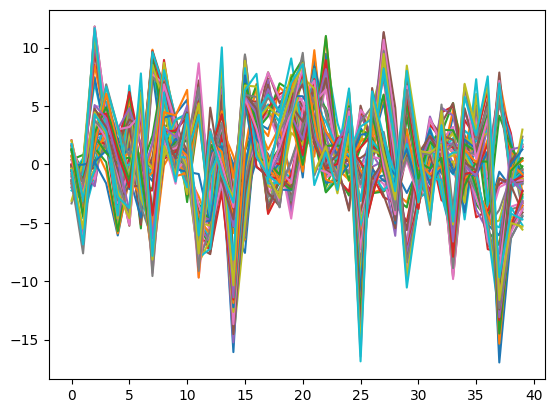

In [4]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

Apply the k-means to the time series just generated. 

In [5]:
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=10, n_clusters=5, random_state=0)

Plot the cluster centers to see if there are differences among the different centroids.

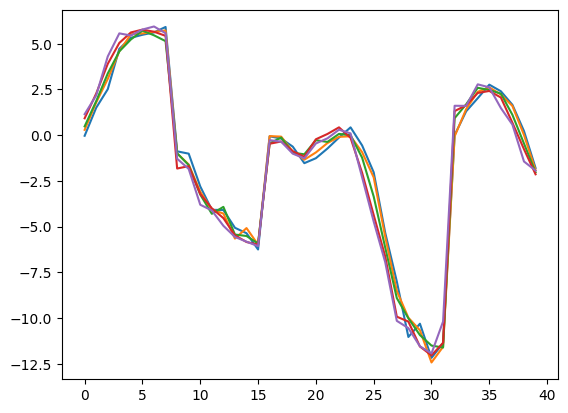

In [7]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

We can change the metric to see if we can separate better the clusters

In [8]:
km_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0)

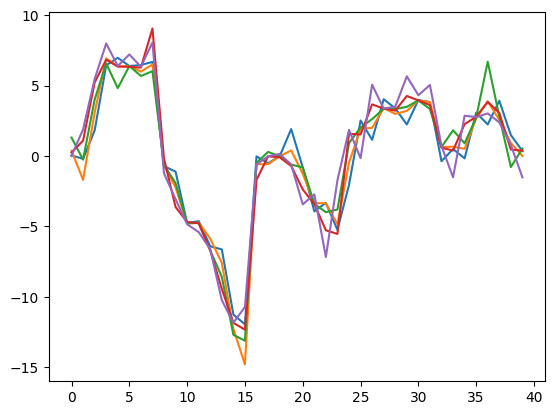

In [9]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

In [10]:
km.inertia_

187.22879139612849

In [11]:
km_dtw.inertia_

44.62441800121187

### 2. Feature-based clustering 
We can apply the clustering to the features extracted. In this case the clustering tecnique applied is the tabular one. 

In [16]:
import scipy.stats as stats
import numpy as np

# from timseries to a vector of feature, then we can use classical clustering algorithms like kmeans
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [17]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(F)

KMeans(n_clusters=5)

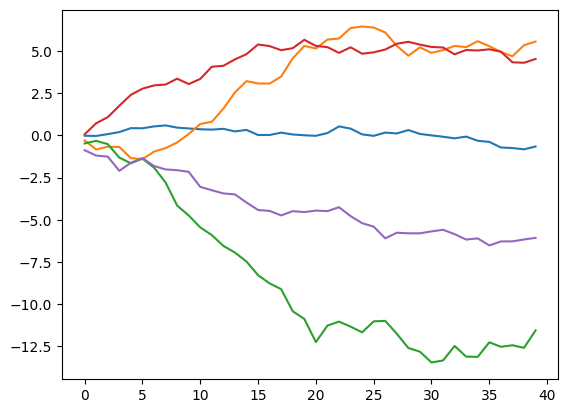

In [20]:
# we need a way to correctly plot the centroids, since the data were a timeseries
# we plot the mean of the timeseries
# go back to timeseries pace rater then vector of feature

# compute the mean of all the timeseries on the same cluster
for i in range(5):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

# green line -> decreasing trend for all the timeseries on that cluster

In [22]:
kmeans.inertia_

1250.1029858719999

### 3. Compression-based clustering (ENCODING)


In [24]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [25]:
from sklearn.metrics import pairwise_distances
import zlib
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [26]:
M

array([[0.52125   , 0.9861461 , 0.975     , ..., 0.98234552, 0.97619048,
        0.97869674],
       [0.9861461 , 0.51903553, 0.9861461 , ..., 0.98602287, 0.97979798,
        0.98106061],
       [0.975     , 0.9861461 , 0.52125   , ..., 0.98865069, 0.97243108,
        0.97619048],
       ...,
       [0.98234552, 0.98602287, 0.98865069, ..., 0.51653944, 0.97724399,
        0.97597977],
       [0.97619048, 0.97979798, 0.97243108, ..., 0.97724399, 0.51758794,
        0.9798995 ],
       [0.97869674, 0.98106061, 0.97619048, ..., 0.97597977, 0.9798995 ,
        0.51633166]])

In [27]:
M.shape

(60, 60)

In [30]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(M) # on the encoded matrix

DBSCAN(eps=0.965, metric='precomputed')

In [31]:
from tslearn.piecewise import PiecewiseAggregateApproximation
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

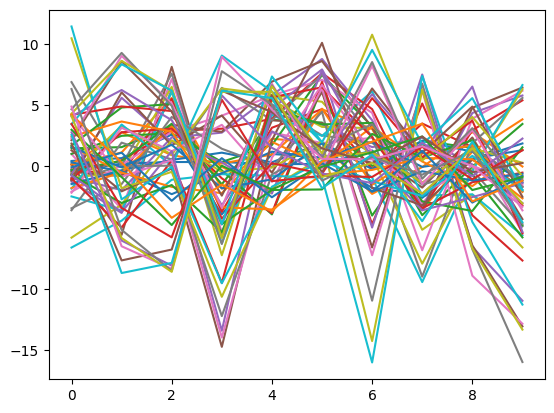

In [32]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [33]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(max_iter=5, random_state=0)

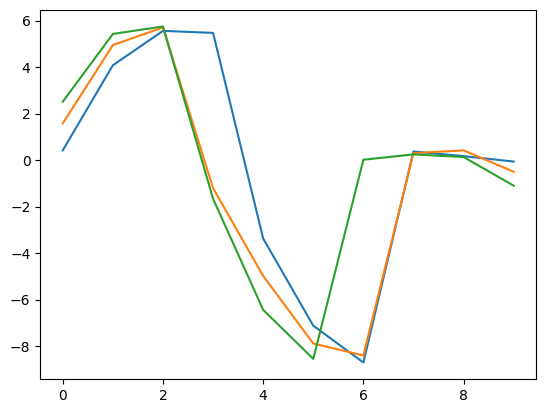

In [34]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 3))
plt.show()

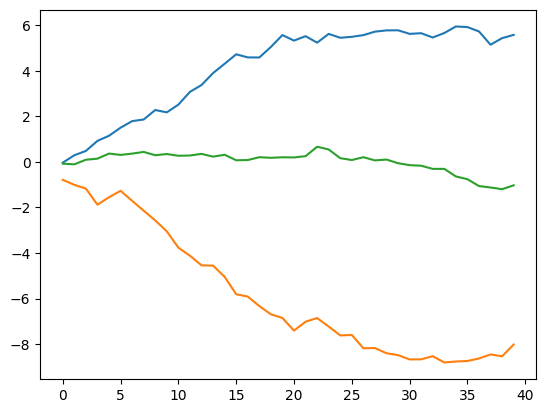

In [35]:
for i in range(3):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()